# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) most higly correlated with Investment growth (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'               # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11831
EM converged at iteration 22, llf=-11668, convergence criterion=9.8272e-07 < tolerance=1e-06
EM start iterations, llf=-11843
EM converged at iteration 23, llf=-11679, convergence criterion=8.4321e-07 < tolerance=1e-06
EM start iterations, llf=-11899
EM converged at iteration 23, llf=-11733, convergence criterion=9.4953e-07 < tolerance=1e-06
EM start iterations, llf=-11906
EM converged at iteration 23, llf=-11740, convergence criterion=9.3139e-07 < tolerance=1e-06
EM start iterations, llf=-11974
EM converged at iteration 24, llf=-11808, convergence criterion=8.8287e-07 < tolerance=1e-06
EM start iterations, llf=-11983
EM converged at iteration 24, llf=-11818, convergence criterion=8.7938e-07 < tolerance=1e-06
EM start iterations, llf=-12041
EM converged at iteration 22, llf=-11879, convergence criterion=8.3624e-07 < tolerance=1e-06
EM start iterations, llf=-12041
EM converged at iteration 22, llf=-11879, convergence criterion=8.3624e-07 < tolerance=1e-06


EM start iterations, llf=-13399
EM converged at iteration 14, llf=-13265, convergence criterion=9.6558e-07 < tolerance=1e-06
EM start iterations, llf=-13451
EM converged at iteration 15, llf=-13318, convergence criterion=8.7297e-07 < tolerance=1e-06
EM start iterations, llf=-13461
EM converged at iteration 15, llf=-13329, convergence criterion=8.8508e-07 < tolerance=1e-06
EM start iterations, llf=-13514
EM converged at iteration 15, llf=-13378, convergence criterion=8.7556e-07 < tolerance=1e-06
EM start iterations, llf=-13514
EM converged at iteration 15, llf=-13378, convergence criterion=8.7556e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM converged at iteration 15, llf=-13388, convergence criterion=9.2835e-07 < tolerance=1e-06
EM start iterations, llf=-13572
EM converged at iteration 15, llf=-13435, convergence criterion=9.3857e-07 < tolerance=1e-06
EM start iterations, llf=-13578
EM converged at iteration 15, llf=-13441, convergence criterion=9.3457e-07 < tolerance=1e-06


EM start iterations, llf=-15102
EM converged at iteration 14, llf=-14956, convergence criterion=9.1824e-07 < tolerance=1e-06
EM start iterations, llf=-15102
EM converged at iteration 14, llf=-14956, convergence criterion=9.1824e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM converged at iteration 14, llf=-14966, convergence criterion=9.1485e-07 < tolerance=1e-06
EM start iterations, llf=-15165
EM converged at iteration 14, llf=-15020, convergence criterion=9.3457e-07 < tolerance=1e-06
EM start iterations, llf=-15175
EM converged at iteration 14, llf=-15030, convergence criterion=9.2077e-07 < tolerance=1e-06
EM start iterations, llf=-15224
EM converged at iteration 14, llf=-15078, convergence criterion=9.0787e-07 < tolerance=1e-06
EM start iterations, llf=-15232
EM converged at iteration 14, llf=-15086, convergence criterion=8.9919e-07 < tolerance=1e-06
EM start iterations, llf=-15279
EM converged at iteration 14, llf=-15134, convergence criterion=8.9591e-07 < tolerance=1e-06


EM start iterations, llf=-16843
EM converged at iteration 13, llf=-16687, convergence criterion=9.5103e-07 < tolerance=1e-06
EM start iterations, llf=-16847
EM converged at iteration 13, llf=-16691, convergence criterion=9.5905e-07 < tolerance=1e-06
EM start iterations, llf=-16900
EM converged at iteration 13, llf=-16745, convergence criterion=9.6075e-07 < tolerance=1e-06
EM start iterations, llf=-16908
EM converged at iteration 13, llf=-16753, convergence criterion=9.607e-07 < tolerance=1e-06
EM start iterations, llf=-16965
EM converged at iteration 13, llf=-16809, convergence criterion=9.633e-07 < tolerance=1e-06
EM start iterations, llf=-16965
EM converged at iteration 13, llf=-16809, convergence criterion=9.633e-07 < tolerance=1e-06
EM start iterations, llf=-16973
EM converged at iteration 13, llf=-16815, convergence criterion=9.6087e-07 < tolerance=1e-06
EM start iterations, llf=-17024
EM converged at iteration 13, llf=-16866, convergence criterion=9.3656e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18374
EM converged at iteration 12, llf=-18213, convergence criterion=9.2726e-07 < tolerance=1e-06
EM start iterations, llf=-18437
EM converged at iteration 12, llf=-18276, convergence criterion=8.8988e-07 < tolerance=1e-06
EM start iterations, llf=-18437
EM converged at iteration 12, llf=-18276, convergence criterion=8.8988e-07 < tolerance=1e-06
EM start iterations, llf=-18442
EM converged at iteration 12, llf=-18281, convergence criterion=8.9203e-07 < tolerance=1e-06
EM start iterations, llf=-18493
EM converged at iteration 12, llf=-18332, convergence criterion=9.1077e-07 < tolerance=1e-06
EM start iterations, llf=-18499
EM converged at iteration 12, llf=-18339, convergence criterion=9.1046e-07 < tolerance=1e-06
EM start iterations, llf=-18557
EM converged at iteration 12, llf=-18395, convergence criterion=8.9493e-07 < tolerance=1e-06
EM start iterations, llf=-18565
EM converged at iteration 12, llf=-18402, convergence criterion=8.9747e-07 < tolerance=1e-06


EM converged at iteration 31, llf=-12213, convergence criterion=9.3064e-07 < tolerance=1e-06
EM start iterations, llf=-12400
EM converged at iteration 30, llf=-12206, convergence criterion=9.7792e-07 < tolerance=1e-06
EM start iterations, llf=-12465
EM converged at iteration 24, llf=-12300, convergence criterion=9.4379e-07 < tolerance=1e-06
EM start iterations, llf=-12474
EM converged at iteration 19, llf=-12322, convergence criterion=9.5112e-07 < tolerance=1e-06
EM start iterations, llf=-12462
EM converged at iteration 14, llf=-12322, convergence criterion=8.6141e-07 < tolerance=1e-06
EM start iterations, llf=-12463
EM converged at iteration 13, llf=-12324, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-12466
EM converged at iteration 14, llf=-12332, convergence criterion=8.5831e-07 < tolerance=1e-06
EM start iterations, llf=-12466
EM converged at iteration 14, llf=-12332, convergence criterion=8.5831e-07 < tolerance=1e-06
EM start iterations, llf=-12460


EM start iterations, llf=-13906
EM converged at iteration 14, llf=-13772, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-13936
EM converged at iteration 14, llf=-13805, convergence criterion=9.6287e-07 < tolerance=1e-06
EM start iterations, llf=-13939
EM converged at iteration 14, llf=-13806, convergence criterion=9.8947e-07 < tolerance=1e-06
EM start iterations, llf=-13982
EM converged at iteration 14, llf=-13846, convergence criterion=9.949e-07 < tolerance=1e-06
EM start iterations, llf=-13982
EM converged at iteration 14, llf=-13846, convergence criterion=9.949e-07 < tolerance=1e-06
EM start iterations, llf=-13992
EM converged at iteration 14, llf=-13856, convergence criterion=9.8839e-07 < tolerance=1e-06
EM start iterations, llf=-14047
EM converged at iteration 14, llf=-13910, convergence criterion=9.6528e-07 < tolerance=1e-06
EM start iterations, llf=-14055
EM converged at iteration 14, llf=-13919, convergence criterion=9.61e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-15673
EM converged at iteration 14, llf=-15522, convergence criterion=9.498e-07 < tolerance=1e-06
EM start iterations, llf=-15673
EM converged at iteration 14, llf=-15522, convergence criterion=9.498e-07 < tolerance=1e-06
EM start iterations, llf=-15683
EM converged at iteration 14, llf=-15533, convergence criterion=9.6709e-07 < tolerance=1e-06
EM start iterations, llf=-15737
EM converged at iteration 14, llf=-15587, convergence criterion=9.5546e-07 < tolerance=1e-06
EM start iterations, llf=-15740
EM converged at iteration 14, llf=-15590, convergence criterion=9.7314e-07 < tolerance=1e-06
EM start iterations, llf=-15796
EM converged at iteration 14, llf=-15647, convergence criterion=9.7807e-07 < tolerance=1e-06
EM start iterations, llf=-15801
EM converged at iteration 14, llf=-15652, convergence criterion=9.8163e-07 < tolerance=1e-06
EM start iterations, llf=-15844
EM converged at iteration 14, llf=-15694, convergence criterion=9.8117e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17396
EM converged at iteration 14, llf=-17236, convergence criterion=8.9778e-07 < tolerance=1e-06
EM start iterations, llf=-17402
EM converged at iteration 14, llf=-17242, convergence criterion=8.9316e-07 < tolerance=1e-06
EM start iterations, llf=-17455
EM converged at iteration 14, llf=-17295, convergence criterion=8.9204e-07 < tolerance=1e-06
EM start iterations, llf=-17464
EM converged at iteration 14, llf=-17304, convergence criterion=8.9404e-07 < tolerance=1e-06
EM start iterations, llf=-17512
EM converged at iteration 14, llf=-17351, convergence criterion=8.8953e-07 < tolerance=1e-06
EM start iterations, llf=-17512
EM converged at iteration 14, llf=-17351, convergence criterion=8.8953e-07 < tolerance=1e-06
EM start iterations, llf=-17531
EM converged at iteration 14, llf=-17371, convergence criterion=8.8783e-07 < tolerance=1e-06
EM start iterations, llf=-17584
EM converged at iteration 14, llf=-17423, convergence criterion=8.7988e-07 < tolerance=1e-06


EM start iterations, llf=-18923
EM converged at iteration 13, llf=-18758, convergence criterion=8.6998e-07 < tolerance=1e-06
EM start iterations, llf=-18974
EM converged at iteration 13, llf=-18808, convergence criterion=8.7462e-07 < tolerance=1e-06
EM start iterations, llf=-18974
EM converged at iteration 13, llf=-18808, convergence criterion=8.7462e-07 < tolerance=1e-06
EM start iterations, llf=-18982
EM converged at iteration 13, llf=-18816, convergence criterion=8.7212e-07 < tolerance=1e-06
EM start iterations, llf=-19037
EM converged at iteration 13, llf=-18871, convergence criterion=8.6841e-07 < tolerance=1e-06
EM start iterations, llf=-19046
EM converged at iteration 13, llf=-18879, convergence criterion=8.7177e-07 < tolerance=1e-06
EM start iterations, llf=-19098
EM converged at iteration 13, llf=-18931, convergence criterion=8.7177e-07 < tolerance=1e-06
EM start iterations, llf=-19107
EM converged at iteration 13, llf=-18941, convergence criterion=8.7004e-07 < tolerance=1e-06


EM converged at iteration 45, llf=-12600, convergence criterion=9.9259e-07 < tolerance=1e-06
EM start iterations, llf=-12739
EM converged at iteration 45, llf=-12609, convergence criterion=9.7569e-07 < tolerance=1e-06
EM start iterations, llf=-12790
EM converged at iteration 44, llf=-12660, convergence criterion=9.7872e-07 < tolerance=1e-06
EM start iterations, llf=-12801
EM converged at iteration 45, llf=-12671, convergence criterion=9.764e-07 < tolerance=1e-06
EM start iterations, llf=-12848
EM converged at iteration 42, llf=-12721, convergence criterion=9.7364e-07 < tolerance=1e-06
EM start iterations, llf=-12860
EM converged at iteration 42, llf=-12732, convergence criterion=9.8446e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 37, llf=-12787, convergence criterion=9.8311e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 37, llf=-12787, convergence criterion=9.8311e-07 < tolerance=1e-06
EM start iterations, llf=-12923
E

EM start iterations, llf=-14429
EM converged at iteration 23, llf=-14289, convergence criterion=9.8023e-07 < tolerance=1e-06
EM start iterations, llf=-14480
EM converged at iteration 23, llf=-14340, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-14490
EM converged at iteration 24, llf=-14350, convergence criterion=9.9566e-07 < tolerance=1e-06
EM start iterations, llf=-14542
EM converged at iteration 24, llf=-14402, convergence criterion=9.6264e-07 < tolerance=1e-06
EM start iterations, llf=-14542
EM converged at iteration 24, llf=-14402, convergence criterion=9.6264e-07 < tolerance=1e-06
EM start iterations, llf=-14552
EM converged at iteration 23, llf=-14411, convergence criterion=9.8953e-07 < tolerance=1e-06
EM start iterations, llf=-14606
EM converged at iteration 23, llf=-14466, convergence criterion=9.691e-07 < tolerance=1e-06
EM start iterations, llf=-14615
EM converged at iteration 23, llf=-14475, convergence criterion=9.9489e-07 < tolerance=1e-06
E

EM start iterations, llf=-16218
EM converged at iteration 27, llf=-16071, convergence criterion=9.8073e-07 < tolerance=1e-06
EM start iterations, llf=-16218
EM converged at iteration 27, llf=-16071, convergence criterion=9.8073e-07 < tolerance=1e-06
EM start iterations, llf=-16228
EM converged at iteration 27, llf=-16081, convergence criterion=9.7941e-07 < tolerance=1e-06
EM start iterations, llf=-16282
EM converged at iteration 27, llf=-16135, convergence criterion=9.7468e-07 < tolerance=1e-06
EM start iterations, llf=-16290
EM converged at iteration 27, llf=-16144, convergence criterion=9.6626e-07 < tolerance=1e-06
EM start iterations, llf=-16341
EM converged at iteration 27, llf=-16194, convergence criterion=9.6836e-07 < tolerance=1e-06
EM start iterations, llf=-16349
EM converged at iteration 27, llf=-16202, convergence criterion=9.698e-07 < tolerance=1e-06
EM start iterations, llf=-16405
EM converged at iteration 27, llf=-16257, convergence criterion=9.62e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-17943
EM converged at iteration 24, llf=-17785, convergence criterion=9.7522e-07 < tolerance=1e-06
EM start iterations, llf=-17948
EM converged at iteration 24, llf=-17790, convergence criterion=9.7886e-07 < tolerance=1e-06
EM start iterations, llf=-18000
EM converged at iteration 24, llf=-17841, convergence criterion=9.8397e-07 < tolerance=1e-06
EM start iterations, llf=-18008
EM converged at iteration 24, llf=-17848, convergence criterion=9.8514e-07 < tolerance=1e-06
EM start iterations, llf=-18063
EM converged at iteration 24, llf=-17904, convergence criterion=9.7681e-07 < tolerance=1e-06
EM start iterations, llf=-18063
EM converged at iteration 24, llf=-17904, convergence criterion=9.7681e-07 < tolerance=1e-06
EM start iterations, llf=-18069
EM converged at iteration 24, llf=-17910, convergence criterion=9.796e-07 < tolerance=1e-06
EM start iterations, llf=-18123
EM converged at iteration 24, llf=-17964, convergence criterion=9.8414e-07 < tolerance=1e-06
E

EM start iterations, llf=-19195
EM converged at iteration 21, llf=-19035, convergence criterion=9.7049e-07 < tolerance=1e-06
EM start iterations, llf=-19250
EM converged at iteration 21, llf=-19089, convergence criterion=9.8231e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 0:50:38.981791.
EM start iterations, llf=-11339
EM converged at iteration 27, llf=-11211, convergence criterion=9.5683e-07 < tolerance=1e-06
EM start iterations, llf=-11351
EM converged at iteration 26, llf=-11223, convergence criterion=9.9436e-07 < tolerance=1e-06
EM start iterations, llf=-11400
EM converged at iteration 26, llf=-11273, convergence criterion=9.5805e-07 < tolerance=1e-06
EM start iterations, llf=-11408
EM converged at iteration 26, llf=-11280, convergence criterion=9.6213e-07 < tolerance=1e-06
EM start iterations, llf=-11464
EM converged at iteration 24, llf=-11336, convergence criterion=9.8007e-07 < tolerance=1e-06
EM start iterations, llf=-11471
EM converged at iter

EM start iterations, llf=-12759
EM converged at iteration 30, llf=-12611, convergence criterion=9.6919e-07 < tolerance=1e-06
EM start iterations, llf=-12768
EM converged at iteration 30, llf=-12619, convergence criterion=9.6796e-07 < tolerance=1e-06
EM start iterations, llf=-12811
EM converged at iteration 30, llf=-12661, convergence criterion=9.2975e-07 < tolerance=1e-06
EM start iterations, llf=-12815
EM converged at iteration 29, llf=-12663, convergence criterion=9.9892e-07 < tolerance=1e-06
EM start iterations, llf=-12832
EM converged at iteration 29, llf=-12686, convergence criterion=9.5066e-07 < tolerance=1e-06
EM start iterations, llf=-12853
EM converged at iteration 29, llf=-12703, convergence criterion=9.857e-07 < tolerance=1e-06
EM start iterations, llf=-12901
EM converged at iteration 29, llf=-12749, convergence criterion=9.4853e-07 < tolerance=1e-06
EM start iterations, llf=-12901
EM converged at iteration 29, llf=-12749, convergence criterion=9.4853e-07 < tolerance=1e-06
E

EM start iterations, llf=-14332
EM converged at iteration 26, llf=-14160, convergence criterion=9.642e-07 < tolerance=1e-06
EM start iterations, llf=-14380
EM converged at iteration 26, llf=-14209, convergence criterion=9.4944e-07 < tolerance=1e-06
EM start iterations, llf=-14388
EM converged at iteration 26, llf=-14217, convergence criterion=9.5498e-07 < tolerance=1e-06
EM start iterations, llf=-14439
EM converged at iteration 25, llf=-14271, convergence criterion=9.7292e-07 < tolerance=1e-06
EM start iterations, llf=-14439
EM converged at iteration 25, llf=-14271, convergence criterion=9.7292e-07 < tolerance=1e-06
EM start iterations, llf=-14448
EM converged at iteration 25, llf=-14279, convergence criterion=9.6477e-07 < tolerance=1e-06
EM start iterations, llf=-14500
EM converged at iteration 25, llf=-14330, convergence criterion=9.5485e-07 < tolerance=1e-06
EM start iterations, llf=-14508
EM converged at iteration 25, llf=-14339, convergence criterion=9.4525e-07 < tolerance=1e-06
E

EM start iterations, llf=-16032
EM converged at iteration 24, llf=-15855, convergence criterion=9.3733e-07 < tolerance=1e-06
EM start iterations, llf=-16032
EM converged at iteration 24, llf=-15855, convergence criterion=9.3733e-07 < tolerance=1e-06
EM start iterations, llf=-16045
EM converged at iteration 24, llf=-15869, convergence criterion=9.3771e-07 < tolerance=1e-06
EM start iterations, llf=-16106
EM converged at iteration 24, llf=-15930, convergence criterion=9.4142e-07 < tolerance=1e-06
EM start iterations, llf=-16110
EM converged at iteration 24, llf=-15934, convergence criterion=9.4114e-07 < tolerance=1e-06
EM start iterations, llf=-16162
EM converged at iteration 24, llf=-15986, convergence criterion=9.3261e-07 < tolerance=1e-06
EM start iterations, llf=-16169
EM converged at iteration 24, llf=-15993, convergence criterion=9.3074e-07 < tolerance=1e-06
EM start iterations, llf=-16222
EM converged at iteration 24, llf=-16047, convergence criterion=9.3441e-07 < tolerance=1e-06


EM start iterations, llf=-17496
EM converged at iteration 22, llf=-17325, convergence criterion=9.9157e-07 < tolerance=1e-06
EM start iterations, llf=-17508
EM converged at iteration 22, llf=-17337, convergence criterion=9.8846e-07 < tolerance=1e-06
EM start iterations, llf=-17566
EM converged at iteration 22, llf=-17395, convergence criterion=9.6953e-07 < tolerance=1e-06
EM start iterations, llf=-17571
EM converged at iteration 22, llf=-17399, convergence criterion=9.7116e-07 < tolerance=1e-06
EM start iterations, llf=-17634
EM converged at iteration 22, llf=-17461, convergence criterion=9.561e-07 < tolerance=1e-06
EM start iterations, llf=-17634
EM converged at iteration 22, llf=-17461, convergence criterion=9.561e-07 < tolerance=1e-06
EM start iterations, llf=-17640
EM converged at iteration 22, llf=-17467, convergence criterion=9.5754e-07 < tolerance=1e-06
EM start iterations, llf=-17688
EM converged at iteration 22, llf=-17515, convergence criterion=9.443e-07 < tolerance=1e-06
EM 

EM converged at iteration 24, llf=-11669, convergence criterion=9.9514e-07 < tolerance=1e-06
EM start iterations, llf=-11816
EM converged at iteration 24, llf=-11681, convergence criterion=9.8359e-07 < tolerance=1e-06
EM start iterations, llf=-11875
EM converged at iteration 21, llf=-11744, convergence criterion=9.6295e-07 < tolerance=1e-06
EM start iterations, llf=-11875
EM converged at iteration 21, llf=-11744, convergence criterion=9.6295e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 23, llf=-11752, convergence criterion=9.5765e-07 < tolerance=1e-06
EM start iterations, llf=-11933
EM converged at iteration 26, llf=-11812, convergence criterion=9.4305e-07 < tolerance=1e-06
EM start iterations, llf=-11917
EM converged at iteration 25, llf=-11794, convergence criterion=9.5697e-07 < tolerance=1e-06
EM start iterations, llf=-11873
EM converged at iteration 28, llf=-11741, convergence criterion=9.4667e-07 < tolerance=1e-06
EM start iterations, llf=-11876


EM start iterations, llf=-13230
EM converged at iteration 36, llf=-13068, convergence criterion=9.5745e-07 < tolerance=1e-06
EM start iterations, llf=-13242
EM converged at iteration 36, llf=-13080, convergence criterion=9.5526e-07 < tolerance=1e-06
EM start iterations, llf=-13273
EM converged at iteration 36, llf=-13110, convergence criterion=9.6681e-07 < tolerance=1e-06
EM start iterations, llf=-13288
EM converged at iteration 37, llf=-13125, convergence criterion=9.528e-07 < tolerance=1e-06
EM start iterations, llf=-13323
EM converged at iteration 37, llf=-13159, convergence criterion=9.7001e-07 < tolerance=1e-06
EM start iterations, llf=-13323
EM converged at iteration 36, llf=-13159, convergence criterion=9.9792e-07 < tolerance=1e-06
EM start iterations, llf=-13363
EM converged at iteration 36, llf=-13196, convergence criterion=9.6366e-07 < tolerance=1e-06
EM start iterations, llf=-13363
EM converged at iteration 36, llf=-13196, convergence criterion=9.6366e-07 < tolerance=1e-06
E

EM start iterations, llf=-14867
EM converged at iteration 28, llf=-14697, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-14920
EM converged at iteration 28, llf=-14751, convergence criterion=9.6321e-07 < tolerance=1e-06
EM start iterations, llf=-14925
EM converged at iteration 28, llf=-14756, convergence criterion=9.6602e-07 < tolerance=1e-06
EM start iterations, llf=-14983
EM converged at iteration 29, llf=-14810, convergence criterion=9.4638e-07 < tolerance=1e-06
EM start iterations, llf=-14983
EM converged at iteration 29, llf=-14810, convergence criterion=9.4638e-07 < tolerance=1e-06
EM start iterations, llf=-14988
EM converged at iteration 28, llf=-14817, convergence criterion=9.773e-07 < tolerance=1e-06
EM start iterations, llf=-15035
EM converged at iteration 28, llf=-14866, convergence criterion=9.7061e-07 < tolerance=1e-06
EM start iterations, llf=-15044
EM converged at iteration 29, llf=-14874, convergence criterion=9.5291e-07 < tolerance=1e-06
E

EM start iterations, llf=-16573
EM converged at iteration 26, llf=-16397, convergence criterion=9.8288e-07 < tolerance=1e-06
EM start iterations, llf=-16573
EM converged at iteration 26, llf=-16397, convergence criterion=9.8288e-07 < tolerance=1e-06
EM start iterations, llf=-16577
EM converged at iteration 26, llf=-16401, convergence criterion=9.6792e-07 < tolerance=1e-06
EM start iterations, llf=-16626
EM converged at iteration 26, llf=-16450, convergence criterion=9.3685e-07 < tolerance=1e-06
EM start iterations, llf=-16632
EM converged at iteration 26, llf=-16456, convergence criterion=9.3506e-07 < tolerance=1e-06
EM start iterations, llf=-16684
EM converged at iteration 26, llf=-16509, convergence criterion=9.3728e-07 < tolerance=1e-06
EM start iterations, llf=-16692
EM converged at iteration 26, llf=-16517, convergence criterion=9.3862e-07 < tolerance=1e-06
EM start iterations, llf=-16738
EM converged at iteration 26, llf=-16562, convergence criterion=9.5344e-07 < tolerance=1e-06


EM start iterations, llf=-18033
EM converged at iteration 24, llf=-17858, convergence criterion=9.979e-07 < tolerance=1e-06
EM start iterations, llf=-18038
EM converged at iteration 24, llf=-17863, convergence criterion=9.9182e-07 < tolerance=1e-06
EM start iterations, llf=-18090
EM converged at iteration 24, llf=-17915, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-18098
EM converged at iteration 24, llf=-17923, convergence criterion=9.7974e-07 < tolerance=1e-06
EM start iterations, llf=-18145
EM converged at iteration 24, llf=-17970, convergence criterion=9.977e-07 < tolerance=1e-06
EM start iterations, llf=-18145
EM converged at iteration 24, llf=-17970, convergence criterion=9.977e-07 < tolerance=1e-06
EM start iterations, llf=-18150
EM converged at iteration 24, llf=-17975, convergence criterion=9.8525e-07 < tolerance=1e-06
EM start iterations, llf=-18203
EM converged at iteration 24, llf=-18029, convergence criterion=9.9263e-07 < tolerance=1e-06
EM 

EM converged at iteration 59, llf=-11917, convergence criterion=9.9633e-07 < tolerance=1e-06
EM start iterations, llf=-12072
EM converged at iteration 59, llf=-11926, convergence criterion=9.9074e-07 < tolerance=1e-06
EM start iterations, llf=-12121
EM converged at iteration 60, llf=-11972, convergence criterion=9.8017e-07 < tolerance=1e-06
EM start iterations, llf=-12121
EM converged at iteration 60, llf=-11972, convergence criterion=9.8017e-07 < tolerance=1e-06
EM start iterations, llf=-12142
EM converged at iteration 58, llf=-11993, convergence criterion=9.8224e-07 < tolerance=1e-06
EM start iterations, llf=-12203
EM converged at iteration 60, llf=-12053, convergence criterion=9.9147e-07 < tolerance=1e-06
EM start iterations, llf=-12217
EM converged at iteration 60, llf=-12067, convergence criterion=9.7787e-07 < tolerance=1e-06
EM start iterations, llf=-12276
EM converged at iteration 61, llf=-12125, convergence criterion=9.9769e-07 < tolerance=1e-06
EM start iterations, llf=-12287


EM start iterations, llf=-13706
EM converged at iteration 47, llf=-13538, convergence criterion=9.5963e-07 < tolerance=1e-06
EM start iterations, llf=-13720
EM converged at iteration 47, llf=-13549, convergence criterion=9.5798e-07 < tolerance=1e-06
EM start iterations, llf=-13777
EM converged at iteration 46, llf=-13604, convergence criterion=9.786e-07 < tolerance=1e-06
EM start iterations, llf=-13783
EM converged at iteration 46, llf=-13610, convergence criterion=9.8309e-07 < tolerance=1e-06
EM start iterations, llf=-13836
EM converged at iteration 45, llf=-13662, convergence criterion=9.8181e-07 < tolerance=1e-06
EM start iterations, llf=-13851
EM converged at iteration 45, llf=-13676, convergence criterion=9.8348e-07 < tolerance=1e-06
EM start iterations, llf=-13902
EM converged at iteration 45, llf=-13728, convergence criterion=9.6223e-07 < tolerance=1e-06
EM start iterations, llf=-13902
EM converged at iteration 45, llf=-13728, convergence criterion=9.6223e-07 < tolerance=1e-06
E

EM start iterations, llf=-15393
EM converged at iteration 43, llf=-15217, convergence criterion=9.7169e-07 < tolerance=1e-06
EM start iterations, llf=-15450
EM converged at iteration 43, llf=-15272, convergence criterion=9.5848e-07 < tolerance=1e-06
EM start iterations, llf=-15455
EM converged at iteration 43, llf=-15278, convergence criterion=9.6091e-07 < tolerance=1e-06
EM start iterations, llf=-15508
EM converged at iteration 43, llf=-15331, convergence criterion=9.6661e-07 < tolerance=1e-06
EM start iterations, llf=-15508
EM converged at iteration 43, llf=-15331, convergence criterion=9.6661e-07 < tolerance=1e-06
EM start iterations, llf=-15519
EM converged at iteration 43, llf=-15341, convergence criterion=9.6489e-07 < tolerance=1e-06
EM start iterations, llf=-15569
EM converged at iteration 43, llf=-15392, convergence criterion=9.6208e-07 < tolerance=1e-06
EM start iterations, llf=-15577
EM converged at iteration 43, llf=-15400, convergence criterion=9.5949e-07 < tolerance=1e-06


EM start iterations, llf=-17100
EM converged at iteration 44, llf=-16923, convergence criterion=9.6959e-07 < tolerance=1e-06
EM start iterations, llf=-17100
EM converged at iteration 44, llf=-16923, convergence criterion=9.6959e-07 < tolerance=1e-06
EM start iterations, llf=-17109
EM converged at iteration 44, llf=-16932, convergence criterion=9.7387e-07 < tolerance=1e-06
EM start iterations, llf=-17156
EM converged at iteration 44, llf=-16980, convergence criterion=9.8199e-07 < tolerance=1e-06
EM start iterations, llf=-17158
EM converged at iteration 44, llf=-16983, convergence criterion=9.7693e-07 < tolerance=1e-06
EM start iterations, llf=-17207
EM converged at iteration 44, llf=-17031, convergence criterion=9.8885e-07 < tolerance=1e-06
EM start iterations, llf=-17215
EM converged at iteration 44, llf=-17039, convergence criterion=9.9679e-07 < tolerance=1e-06
EM start iterations, llf=-17268
EM converged at iteration 46, llf=-17092, convergence criterion=9.6629e-07 < tolerance=1e-06


EM start iterations, llf=-18286
EM converged at iteration 41, llf=-18114, convergence criterion=9.8906e-07 < tolerance=1e-06
EM start iterations, llf=-18296
EM converged at iteration 41, llf=-18124, convergence criterion=9.8696e-07 < tolerance=1e-06
EM start iterations, llf=-18351
EM converged at iteration 41, llf=-18178, convergence criterion=9.9056e-07 < tolerance=1e-06
EM start iterations, llf=-18355
EM converged at iteration 41, llf=-18183, convergence criterion=9.8724e-07 < tolerance=1e-06
EM start iterations, llf=-18408
EM converged at iteration 41, llf=-18236, convergence criterion=9.7524e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 1:40:30.972593.
EM start iterations, llf=-11139
EM converged at iteration 30, llf=-11018, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-11149
EM converged at iteration 33, llf=-11029, convergence criterion=9.9896e-07 < tolerance=1e-06
EM start iterations, llf=-11200
EM converged at iter

EM converged at iteration 35, llf=-12086, convergence criterion=9.6783e-07 < tolerance=1e-06
EM start iterations, llf=-12256
EM converged at iteration 33, llf=-12136, convergence criterion=9.8386e-07 < tolerance=1e-06
EM start iterations, llf=-12289
EM converged at iteration 34, llf=-12172, convergence criterion=9.7184e-07 < tolerance=1e-06
EM start iterations, llf=-12289
EM converged at iteration 34, llf=-12172, convergence criterion=9.7184e-07 < tolerance=1e-06
EM start iterations, llf=-12303
EM converged at iteration 34, llf=-12185, convergence criterion=9.6717e-07 < tolerance=1e-06
EM start iterations, llf=-12336
EM converged at iteration 32, llf=-12216, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-12349
EM converged at iteration 32, llf=-12228, convergence criterion=9.5668e-07 < tolerance=1e-06
EM start iterations, llf=-12426
EM converged at iteration 31, llf=-12296, convergence criterion=9.724e-07 < tolerance=1e-06
EM start iterations, llf=-12416
E

EM start iterations, llf=-13746
EM converged at iteration 29, llf=-13612, convergence criterion=9.8139e-07 < tolerance=1e-06
EM start iterations, llf=-13749
EM converged at iteration 29, llf=-13616, convergence criterion=9.9787e-07 < tolerance=1e-06
EM start iterations, llf=-13800
EM converged at iteration 29, llf=-13669, convergence criterion=9.9453e-07 < tolerance=1e-06
EM start iterations, llf=-13811
EM converged at iteration 29, llf=-13679, convergence criterion=9.7554e-07 < tolerance=1e-06
EM start iterations, llf=-13861
EM converged at iteration 29, llf=-13730, convergence criterion=9.8307e-07 < tolerance=1e-06
EM start iterations, llf=-13869
EM converged at iteration 30, llf=-13738, convergence criterion=9.4202e-07 < tolerance=1e-06
EM start iterations, llf=-13927
EM converged at iteration 30, llf=-13795, convergence criterion=9.4248e-07 < tolerance=1e-06
EM start iterations, llf=-13927
EM converged at iteration 30, llf=-13795, convergence criterion=9.4248e-07 < tolerance=1e-06


EM start iterations, llf=-15399
EM converged at iteration 29, llf=-15265, convergence criterion=9.8486e-07 < tolerance=1e-06
EM start iterations, llf=-15451
EM converged at iteration 29, llf=-15317, convergence criterion=9.9657e-07 < tolerance=1e-06
EM start iterations, llf=-15460
EM converged at iteration 29, llf=-15326, convergence criterion=9.9282e-07 < tolerance=1e-06
EM start iterations, llf=-15503
EM converged at iteration 30, llf=-15369, convergence criterion=9.5915e-07 < tolerance=1e-06
EM start iterations, llf=-15503
EM converged at iteration 30, llf=-15369, convergence criterion=9.5915e-07 < tolerance=1e-06
EM start iterations, llf=-15515
EM converged at iteration 30, llf=-15381, convergence criterion=9.5568e-07 < tolerance=1e-06
EM start iterations, llf=-15574
EM converged at iteration 30, llf=-15440, convergence criterion=9.6851e-07 < tolerance=1e-06
EM start iterations, llf=-15579
EM converged at iteration 30, llf=-15445, convergence criterion=9.663e-07 < tolerance=1e-06
E

EM start iterations, llf=-16884
EM converged at iteration 29, llf=-16751, convergence criterion=9.509e-07 < tolerance=1e-06
EM start iterations, llf=-16884
EM converged at iteration 29, llf=-16751, convergence criterion=9.509e-07 < tolerance=1e-06
EM start iterations, llf=-16892
EM converged at iteration 28, llf=-16758, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-16941
EM converged at iteration 29, llf=-16805, convergence criterion=9.4786e-07 < tolerance=1e-06
EM start iterations, llf=-16951
EM converged at iteration 29, llf=-16814, convergence criterion=9.4421e-07 < tolerance=1e-06
EM start iterations, llf=-17009
EM converged at iteration 29, llf=-16871, convergence criterion=9.6075e-07 < tolerance=1e-06
EM start iterations, llf=-17015
EM converged at iteration 29, llf=-16878, convergence criterion=9.6346e-07 < tolerance=1e-06
EM start iterations, llf=-17078
EM converged at iteration 29, llf=-16940, convergence criterion=9.7074e-07 < tolerance=1e-06
EM

EM converged at iteration 46, llf=-11349, convergence criterion=9.676e-07 < tolerance=1e-06
EM start iterations, llf=-11501
EM converged at iteration 47, llf=-11379, convergence criterion=9.6864e-07 < tolerance=1e-06
EM start iterations, llf=-11505
EM converged at iteration 48, llf=-11383, convergence criterion=9.6952e-07 < tolerance=1e-06
EM start iterations, llf=-11524
EM converged at iteration 51, llf=-11408, convergence criterion=9.7953e-07 < tolerance=1e-06
EM start iterations, llf=-11529
EM converged at iteration 49, llf=-11412, convergence criterion=9.9136e-07 < tolerance=1e-06
EM start iterations, llf=-11611
EM converged at iteration 44, llf=-11487, convergence criterion=9.9491e-07 < tolerance=1e-06
EM start iterations, llf=-11611
EM converged at iteration 44, llf=-11487, convergence criterion=9.9491e-07 < tolerance=1e-06
EM start iterations, llf=-11614
EM converged at iteration 43, llf=-11495, convergence criterion=9.9839e-07 < tolerance=1e-06
EM start iterations, llf=-11664
E

EM start iterations, llf=-12706
EM converged at iteration 34, llf=-12580, convergence criterion=9.7337e-07 < tolerance=1e-06
EM start iterations, llf=-12713
EM converged at iteration 36, llf=-12587, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-12747
EM converged at iteration 37, llf=-12621, convergence criterion=9.7378e-07 < tolerance=1e-06
EM start iterations, llf=-12747
EM converged at iteration 37, llf=-12621, convergence criterion=9.7378e-07 < tolerance=1e-06
EM start iterations, llf=-12756
EM converged at iteration 37, llf=-12632, convergence criterion=9.8094e-07 < tolerance=1e-06
EM start iterations, llf=-12788
EM converged at iteration 34, llf=-12663, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-12796
EM converged at iteration 36, llf=-12671, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-12822
EM converged at iteration 37, llf=-12699, convergence criterion=9.992e-07 < tolerance=1e-06
E

EM start iterations, llf=-14270
EM converged at iteration 39, llf=-14141, convergence criterion=9.8536e-07 < tolerance=1e-06
EM start iterations, llf=-14284
EM converged at iteration 37, llf=-14156, convergence criterion=9.833e-07 < tolerance=1e-06
EM start iterations, llf=-14339
EM converged at iteration 35, llf=-14210, convergence criterion=9.8538e-07 < tolerance=1e-06
EM start iterations, llf=-14347
EM converged at iteration 34, llf=-14219, convergence criterion=9.9089e-07 < tolerance=1e-06
EM start iterations, llf=-14398
EM converged at iteration 34, llf=-14270, convergence criterion=9.9641e-07 < tolerance=1e-06
EM start iterations, llf=-14403
EM converged at iteration 34, llf=-14275, convergence criterion=9.7626e-07 < tolerance=1e-06
EM start iterations, llf=-14453
EM converged at iteration 33, llf=-14328, convergence criterion=9.8208e-07 < tolerance=1e-06
EM start iterations, llf=-14453
EM converged at iteration 33, llf=-14328, convergence criterion=9.8208e-07 < tolerance=1e-06
E

EM start iterations, llf=-15917
EM converged at iteration 39, llf=-15783, convergence criterion=9.8081e-07 < tolerance=1e-06
EM start iterations, llf=-15971
EM converged at iteration 38, llf=-15836, convergence criterion=9.8549e-07 < tolerance=1e-06
EM start iterations, llf=-15980
EM converged at iteration 37, llf=-15846, convergence criterion=9.9952e-07 < tolerance=1e-06
EM start iterations, llf=-16029
EM converged at iteration 37, llf=-15895, convergence criterion=9.7849e-07 < tolerance=1e-06
EM start iterations, llf=-16029
EM converged at iteration 37, llf=-15895, convergence criterion=9.7849e-07 < tolerance=1e-06
EM start iterations, llf=-16039
EM converged at iteration 35, llf=-15904, convergence criterion=9.9995e-07 < tolerance=1e-06
EM start iterations, llf=-16090
EM converged at iteration 33, llf=-15955, convergence criterion=9.8963e-07 < tolerance=1e-06
EM start iterations, llf=-16095
EM converged at iteration 33, llf=-15960, convergence criterion=9.8254e-07 < tolerance=1e-06


EM start iterations, llf=-17404
EM converged at iteration 29, llf=-17267, convergence criterion=9.8428e-07 < tolerance=1e-06
EM start iterations, llf=-17404
EM converged at iteration 29, llf=-17267, convergence criterion=9.8428e-07 < tolerance=1e-06
EM start iterations, llf=-17411
EM converged at iteration 29, llf=-17276, convergence criterion=9.836e-07 < tolerance=1e-06
EM start iterations, llf=-17459
EM converged at iteration 30, llf=-17325, convergence criterion=9.8649e-07 < tolerance=1e-06
EM start iterations, llf=-17468
EM converged at iteration 30, llf=-17333, convergence criterion=9.9095e-07 < tolerance=1e-06
EM start iterations, llf=-17515
EM converged at iteration 30, llf=-17380, convergence criterion=9.8426e-07 < tolerance=1e-06
EM start iterations, llf=-17523
EM converged at iteration 31, llf=-17386, convergence criterion=9.672e-07 < tolerance=1e-06
EM start iterations, llf=-17569
EM converged at iteration 28, llf=-17433, convergence criterion=9.7672e-07 < tolerance=1e-06
EM

EM converged at iteration 78, llf=-11500, convergence criterion=9.9318e-07 < tolerance=1e-06
EM start iterations, llf=-11609
EM converged at iteration 89, llf=-11490, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-11637
EM converged at iteration 84, llf=-11522, convergence criterion=9.8828e-07 < tolerance=1e-06
EM start iterations, llf=-11671
EM converged at iteration 86, llf=-11559, convergence criterion=9.9176e-07 < tolerance=1e-06
EM start iterations, llf=-11676
EM converged at iteration 90, llf=-11562, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-11715
EM converged at iteration 89, llf=-11599, convergence criterion=9.9905e-07 < tolerance=1e-06
EM start iterations, llf=-11715
EM converged at iteration 89, llf=-11599, convergence criterion=9.9905e-07 < tolerance=1e-06
EM start iterations, llf=-11725
EM converged at iteration 85, llf=-11611, convergence criterion=9.9743e-07 < tolerance=1e-06
EM start iterations, llf=-11763


EM start iterations, llf=-13126
EM converged at iteration 76, llf=-12995, convergence criterion=9.9492e-07 < tolerance=1e-06
EM start iterations, llf=-13128
EM converged at iteration 78, llf=-12997, convergence criterion=9.9215e-07 < tolerance=1e-06
EM start iterations, llf=-13172
EM converged at iteration 77, llf=-13039, convergence criterion=9.9756e-07 < tolerance=1e-06
EM start iterations, llf=-13172
EM converged at iteration 77, llf=-13039, convergence criterion=9.9756e-07 < tolerance=1e-06
EM start iterations, llf=-13184
EM converged at iteration 78, llf=-13050, convergence criterion=9.9011e-07 < tolerance=1e-06
EM start iterations, llf=-13244
EM converged at iteration 76, llf=-13109, convergence criterion=9.826e-07 < tolerance=1e-06
EM start iterations, llf=-13250
EM converged at iteration 76, llf=-13115, convergence criterion=9.9043e-07 < tolerance=1e-06
EM start iterations, llf=-13299
EM converged at iteration 77, llf=-13165, convergence criterion=9.9613e-07 < tolerance=1e-06
E

EM start iterations, llf=-14778
EM converged at iteration 73, llf=-14644, convergence criterion=9.8532e-07 < tolerance=1e-06
EM start iterations, llf=-14786
EM converged at iteration 72, llf=-14654, convergence criterion=9.9588e-07 < tolerance=1e-06
EM start iterations, llf=-14840
EM converged at iteration 71, llf=-14706, convergence criterion=9.9347e-07 < tolerance=1e-06
EM start iterations, llf=-14842
EM converged at iteration 72, llf=-14710, convergence criterion=9.8231e-07 < tolerance=1e-06
EM start iterations, llf=-14897
EM converged at iteration 73, llf=-14763, convergence criterion=9.8894e-07 < tolerance=1e-06
EM start iterations, llf=-14904
EM converged at iteration 73, llf=-14770, convergence criterion=9.8626e-07 < tolerance=1e-06
EM start iterations, llf=-14960
EM converged at iteration 73, llf=-14826, convergence criterion=9.8842e-07 < tolerance=1e-06
EM start iterations, llf=-14960
EM converged at iteration 73, llf=-14826, convergence criterion=9.8842e-07 < tolerance=1e-06


EM start iterations, llf=-16433
EM converged at iteration 72, llf=-16294, convergence criterion=9.8088e-07 < tolerance=1e-06
EM start iterations, llf=-16487
EM converged at iteration 73, llf=-16348, convergence criterion=9.8084e-07 < tolerance=1e-06
EM start iterations, llf=-16495
EM converged at iteration 72, llf=-16355, convergence criterion=9.9781e-07 < tolerance=1e-06
EM start iterations, llf=-16544
EM converged at iteration 72, llf=-16404, convergence criterion=9.8865e-07 < tolerance=1e-06
EM start iterations, llf=-16544
EM converged at iteration 72, llf=-16404, convergence criterion=9.8865e-07 < tolerance=1e-06
EM start iterations, llf=-16550
EM converged at iteration 72, llf=-16411, convergence criterion=9.8755e-07 < tolerance=1e-06
EM start iterations, llf=-16598
EM converged at iteration 71, llf=-16459, convergence criterion=9.9204e-07 < tolerance=1e-06
EM start iterations, llf=-16605
EM converged at iteration 71, llf=-16466, convergence criterion=9.8393e-07 < tolerance=1e-06


EM start iterations, llf=-17906
EM converged at iteration 65, llf=-17762, convergence criterion=9.8358e-07 < tolerance=1e-06
EM start iterations, llf=-17906
EM converged at iteration 65, llf=-17762, convergence criterion=9.8358e-07 < tolerance=1e-06
EM start iterations, llf=-17653
EM converged at iteration 63, llf=-17513, convergence criterion=9.8955e-07 < tolerance=1e-06
EM start iterations, llf=-17705
EM converged at iteration 64, llf=-17564, convergence criterion=9.8412e-07 < tolerance=1e-06
EM start iterations, llf=-17717
EM converged at iteration 63, llf=-17577, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-17769
EM converged at iteration 65, llf=-17628, convergence criterion=9.7875e-07 < tolerance=1e-06
EM start iterations, llf=-17773
EM converged at iteration 64, llf=-17632, convergence criterion=9.9639e-07 < tolerance=1e-06
EM start iterations, llf=-17826
EM converged at iteration 64, llf=-17685, convergence criterion=9.9499e-07 < tolerance=1e-06


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


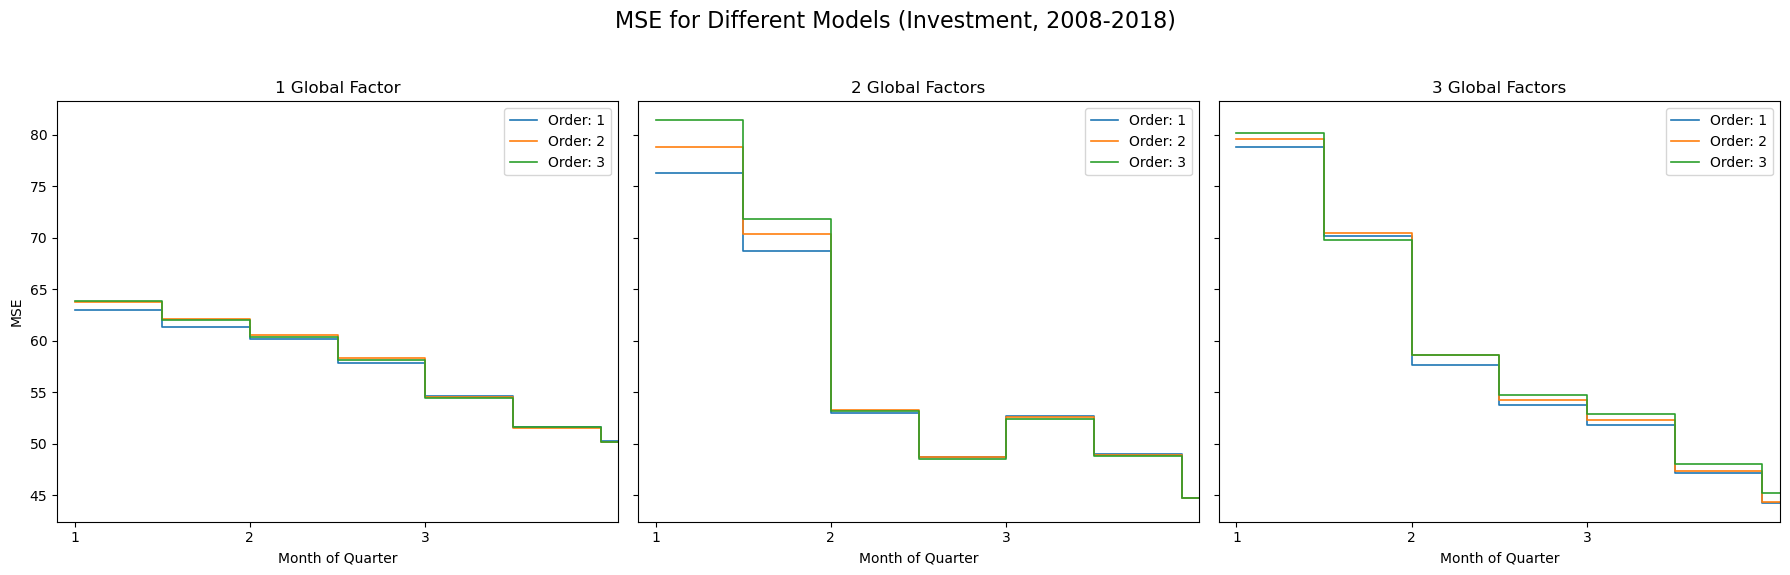

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


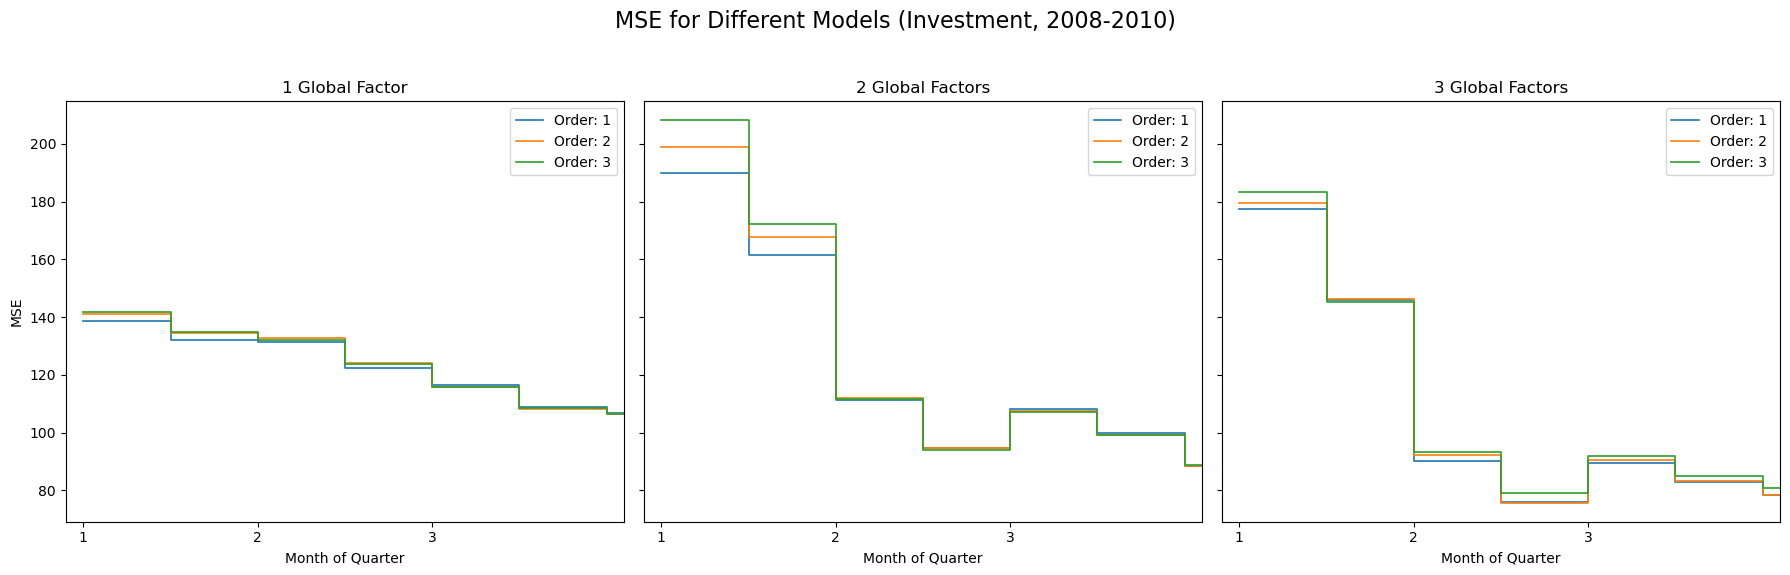

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


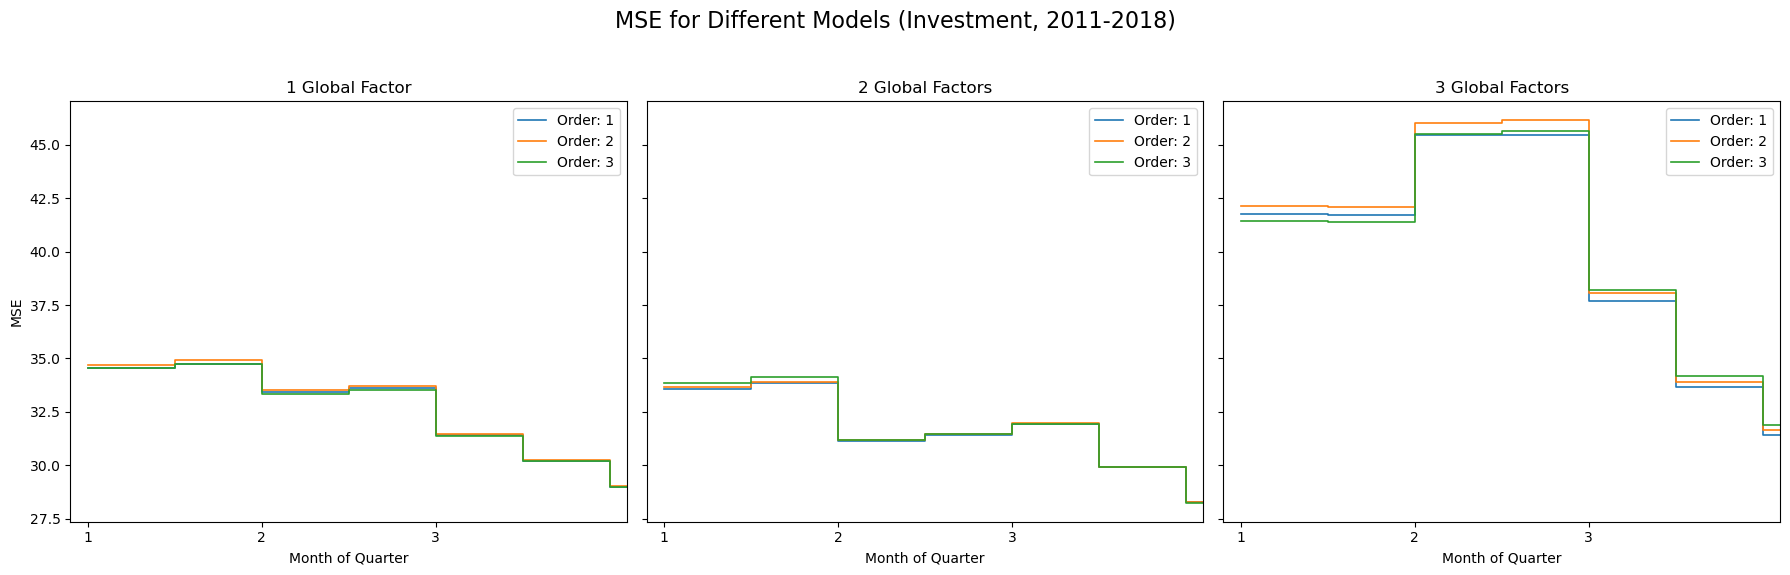

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


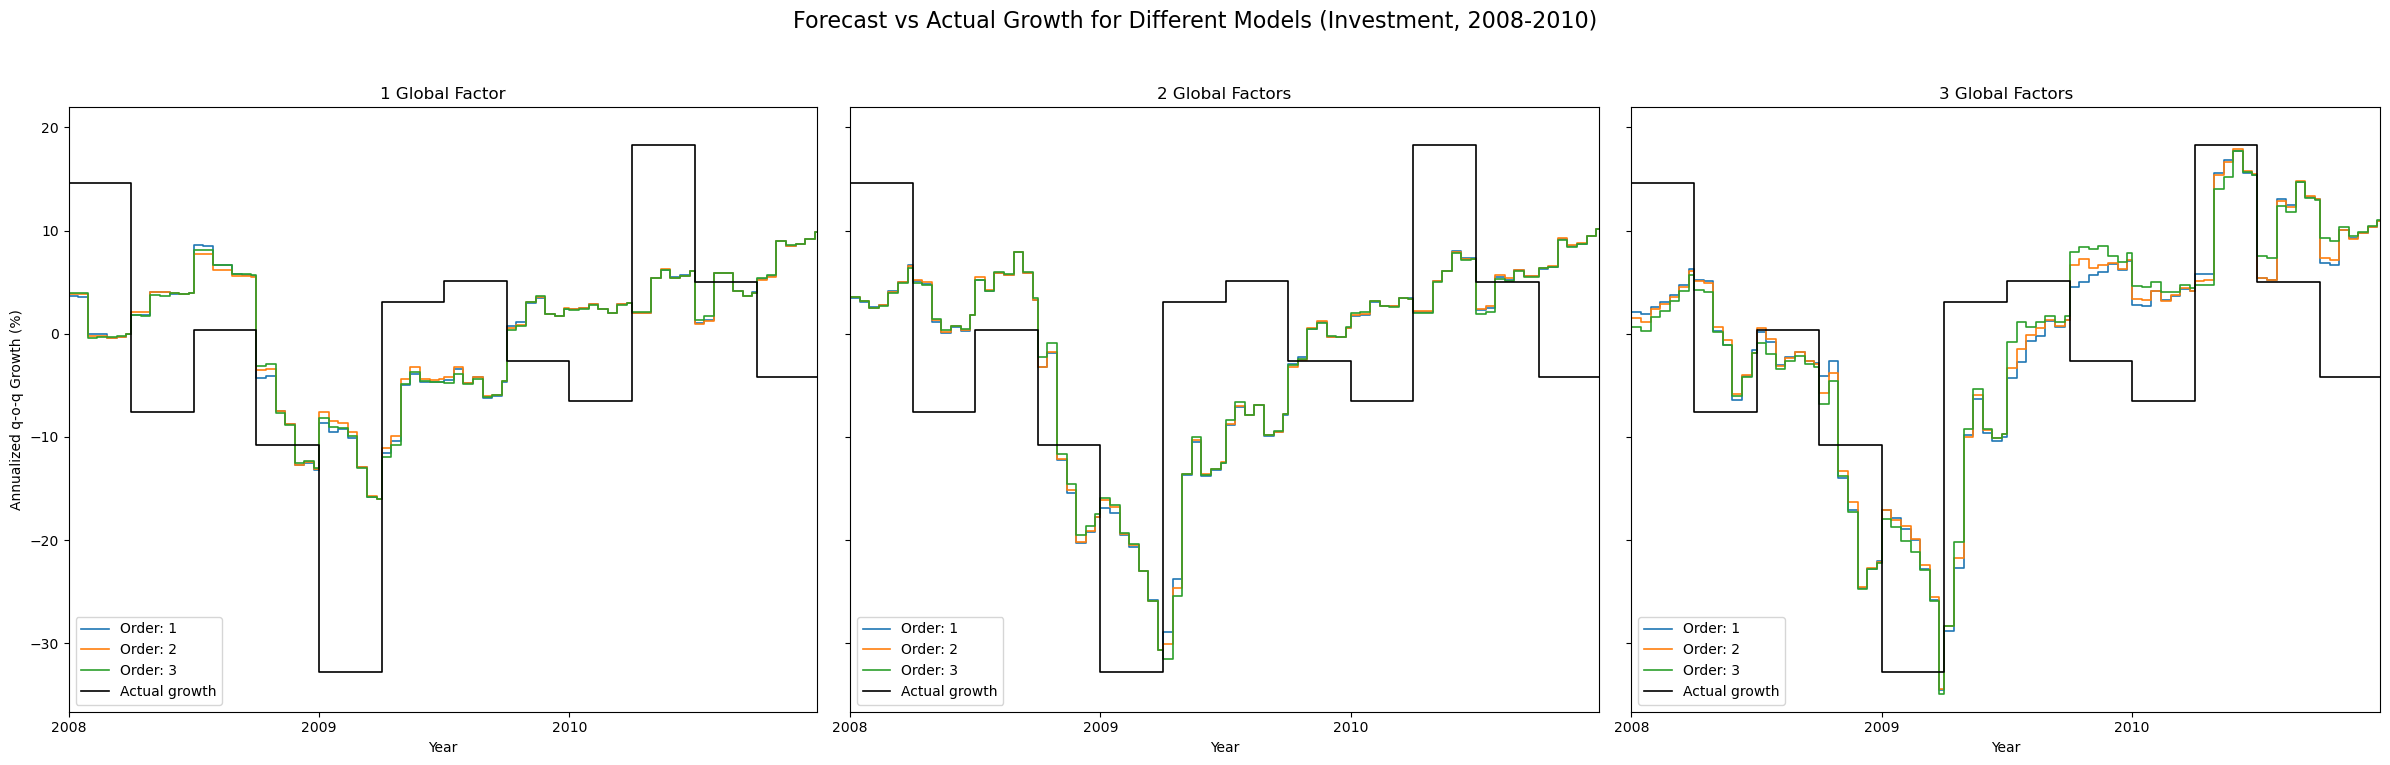

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


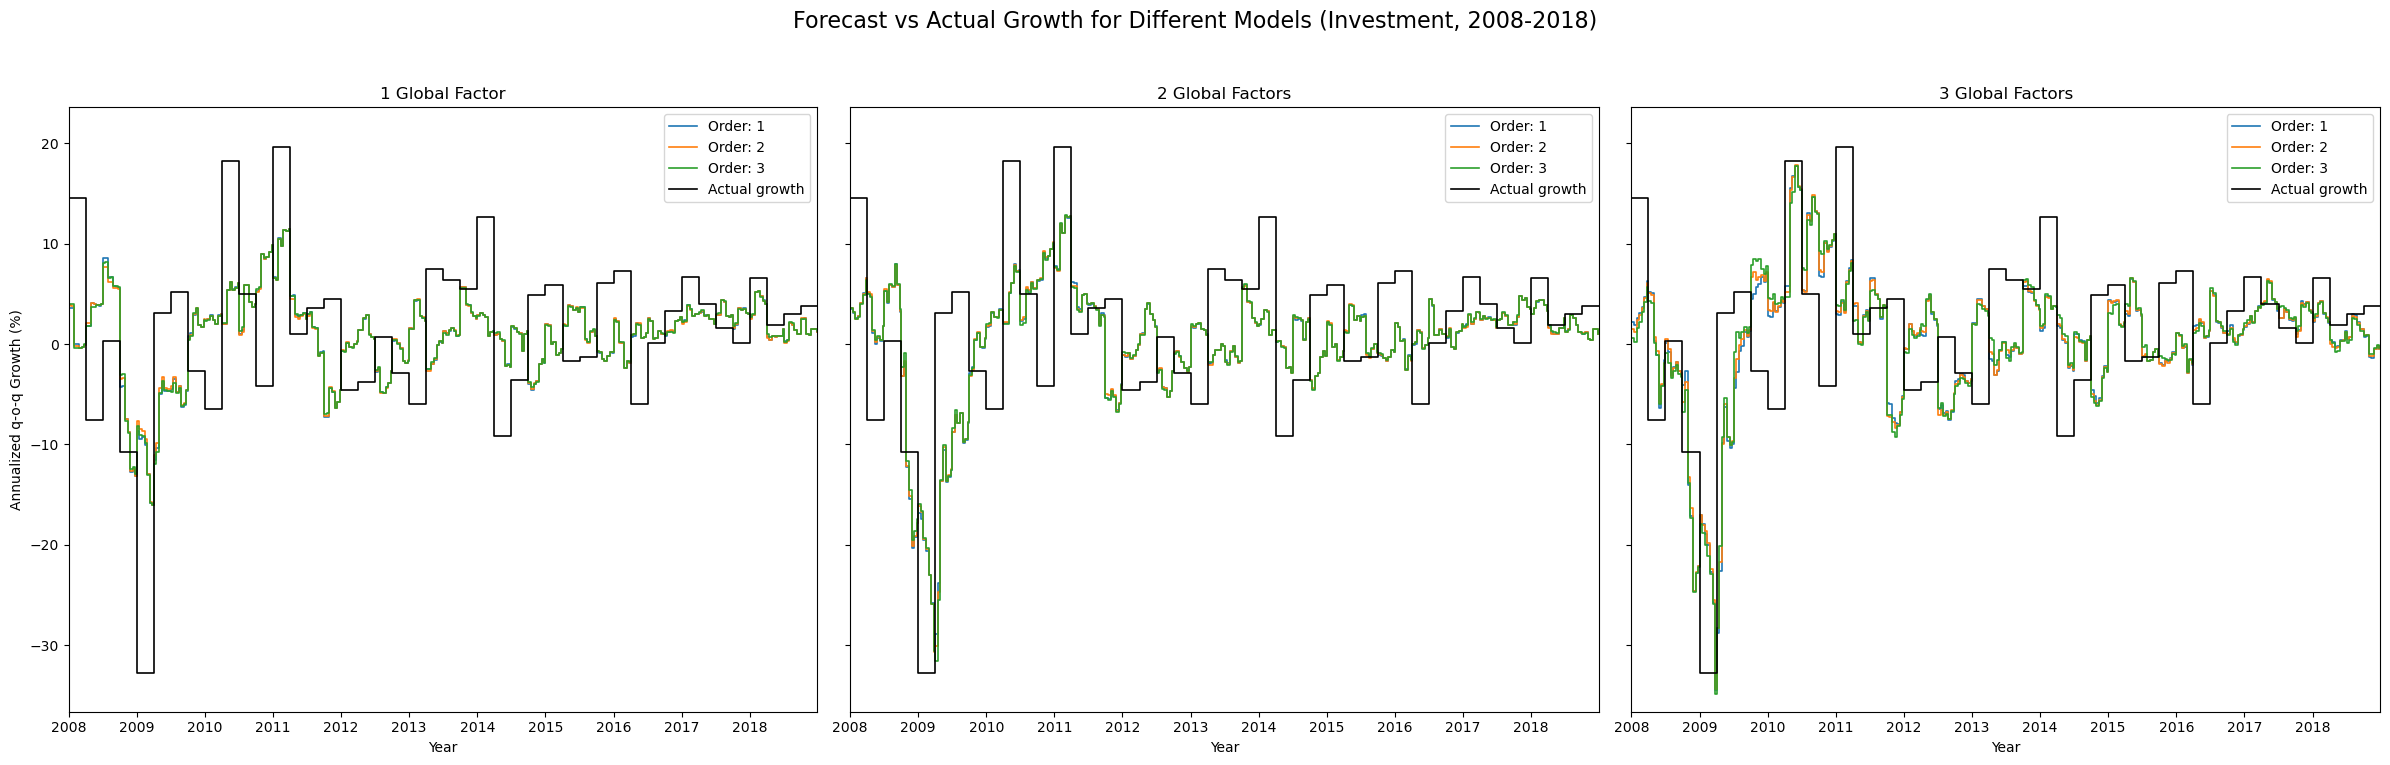

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


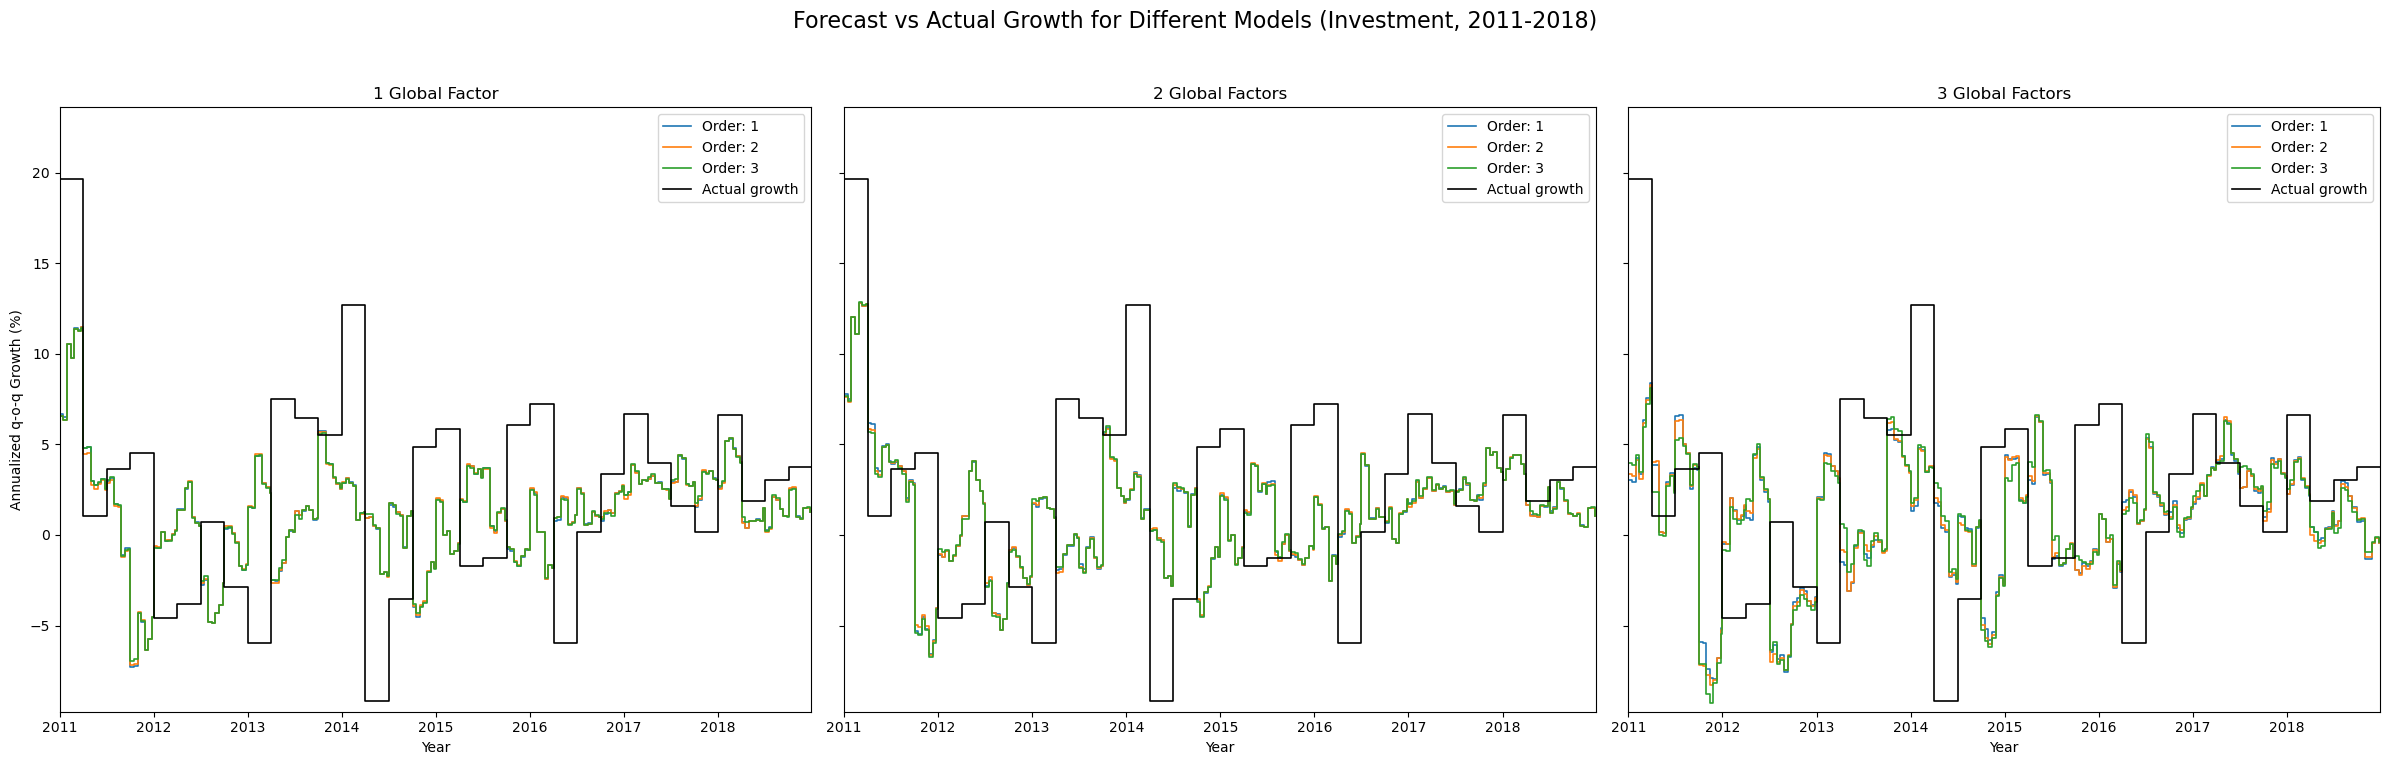

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()